<a href="https://colab.research.google.com/github/mahyarhabibi/GenderGaps_Hollywood/blob/main/Codes/tables_graphs_pub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebood generates the tables and the figures displayed in the paper.

In [1]:
!pip install gender_guesser
!pip install pandas==1.3.2

import gender_guesser.detector as gen
gender = gen.Detector(case_sensitive=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import json

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

# Directories to read data and store results
#Please add the parent folder to your Google Drive
# Public Link: https://drive.google.com/drive/folders/1TYCDAJOCiLZw4TObcLac5GnL5YtwYnUD?usp=sharing
parent_dir = "/content/gdrive/MyDrive/GenderGaps_Hollywood/" # You may need to change the address
data_dir = os.path.join(parent_dir, 'Data/')
results_dir = os.path.join(parent_dir,'Results/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df_movies = pd.read_pickle(data_dir + 'movies_info_merged_MIW_pkl.zip')
df_crevs = pd.read_pickle(data_dir + 'reviews_critics_merged.zip')
df_urevs = pd.read_pickle(data_dir + 'reviews_users_merged.zip')

In [5]:
Table_Sum = df_movies.describe(include=np.number).apply(lambda s: 
                                                    s.apply('{0:.1f}'.format))
plot_vecs = [f'plot_vec{i}' for i in range(100)]
Table_Sum = Table_Sum.drop(columns=plot_vecs)
#Table_Sum.T

In [6]:
online_platforms = ['Netflix', 'Amazon Studios','Hulu','Amazon Prime Video', 
                      'Disney+', 'HBO Max' ]
df_movies['online_plt'] = df_movies['Distributor'].map(lambda x: 
                                            1 if x in online_platforms else 0)

df_boxoff = df_movies.loc[~((df_movies['est_sales'].isna()) | 
                            (df_movies['est_budget'].isna()) |
                          ( df_movies['online_plt']==1))].reset_index(drop=True)
df_boxoff[['est_budget', 'est_sales']].describe().apply(lambda s:
                                                        s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
est_budget,5486.00,32.01,40.26,0.00,7.00,18.00,40.00,317.00
est_sales,5486.00,85.73,167.90,0.00,4.09,25.09,91.74,2847.25


In [7]:
#Since on movie may have several producers, I instead count total number of 
# producers by gender in each period
from collections import Counter
df_prod_temp = df_movies[['period2', 'exec_producer']]
df_prod_temp['EProds'] = df_prod_temp.groupby('period2')['exec_producer'].transform('sum')
df_prod_temp = df_prod_temp.drop(columns= 'exec_producer')
df_prod_temp = df_prod_temp.drop_duplicates(subset= 'period2').reset_index(drop=True)
df_prod_temp['genders'] = df_prod_temp['EProds'].map(lambda x:
                            [gender.get_gender(name.split()[0]) for name in x])

df_prod_temp['male_count'] = df_prod_temp['genders'].map(lambda x: Counter(x)).map(lambda x: x.get('male') + x.get('mostly_male'))
df_prod_temp['female_count'] = df_prod_temp['genders'].map(lambda x: Counter(x)).map(lambda x: x.get('female') + x.get('mostly_female'))

df_prod_count = pd.melt(df_prod_temp, id_vars = 'period2', value_vars = ['male_count', 'female_count'])
df_prod_count['P_Female'] = np.where(df_prod_count['variable']=='female_count',1.0,0.0)
df_prod_count = df_prod_count.rename(columns = {'value': 'count'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
# Shares of Female Directorss, Ex. producers and leading actors
df_shares = df_movies.groupby(['period2'])['D_Female', 'A1_Female', 'A2_Female'].mean()

count_mal_prod = df_prod_count.loc[df_prod_count['P_Female']==0]['count'].values
count_fem_prod = df_prod_count.loc[df_prod_count['P_Female']==1]['count'].values
share_fem_prod  = list(count_fem_prod/ (count_fem_prod + count_mal_prod))

df_shares['P_Female'] = share_fem_prod
df_shares['period'] = df_shares.index
df_shares = pd.melt(df_shares, id_vars='period')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


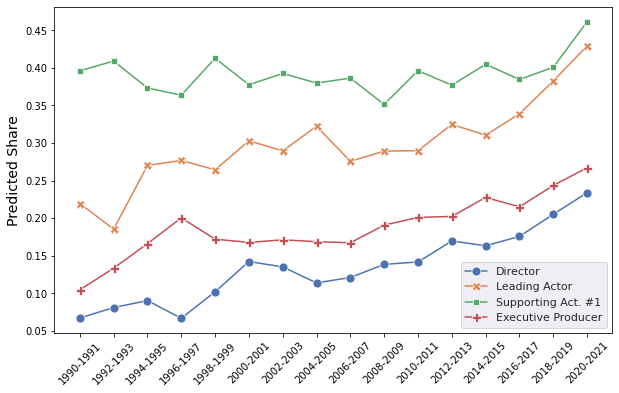

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
sns.set_theme()
sns.lineplot(x='period', y='value', hue = 'variable', data=df_shares,
             style='variable', dashes=False, markers=True,markersize=9)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Predicted Share', fontsize=14)
ax.set_xlabel('')
ax.legend(labels=['Director', 'Leading Actor', 'Supporting Act. #1', 'Executive Producer'])
fig.savefig(results_dir + 'fig_shares.jpg', dpi=300,bbox_inches='tight')

# Quantile Regression Plot

In [10]:
with open(results_dir + 'agg_outcomes_reg_results.json', 'r') as input_file:
  ols_results = json.load(input_file)

df_qreg_sale = pd.read_csv(results_dir + 'qreg_results_sales.csv')
df_qreg_budg = pd.read_csv(results_dir + 'qreg_results_budget.csv')

In [11]:
def qreg_plot(ax, df_qreg, ols_estimate):
  q_values = [round(q,2) for q in df_qreg['q'].values]
  coefs = df_qreg['coef'].values
  ubar = df_qreg['ub'].values
  lbar = df_qreg['lb'].values
  
  labels=[f'{q}' for q in q_values]
  ax.plot(labels, coefs, 'b-', label='mean_1')
  ax.fill_between(labels, lbar, ubar, color='g', alpha=0.2)
  ax.tick_params(axis='x', rotation=90)
  ax.axhline(y= ols_estimate, color = 'r', ls = '--')
  ax.axhline(y= 0, color = 'k')
  ax.text(7, ols_estimate + .03, "OLS Estimate",
          fontsize=13,verticalalignment='top')


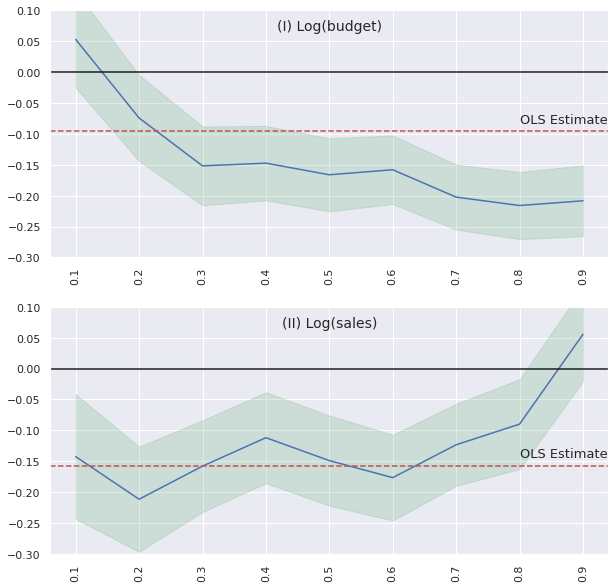

In [12]:
ols_sale = ols_results['Sales']['OLS']['spec5']['coef D_Female'][0]
ols_budg = ols_results['Budget']['OLS']['spec5']['coef D_Female'][0]
sns.set()
fig, axes = plt.subplots(2,1 ,figsize=(10,10))
qreg_plot(axes[0], df_qreg_budg, ols_budg)
qreg_plot(axes[1], df_qreg_sale, ols_sale)

axes[0].set_title("(I) Log(budget)", fontsize=14, y=1.0, pad=-20)
axes[1].set_title("(II) Log(sales)", fontsize=14, y=1.0, pad=-20)

for ax in fig.get_axes():
  ax.set_ylim(-0.30,0.1)
fig.savefig(results_dir + 'quantile_regressions.jpg', dpi=300,bbox_inches='tight')

# Regression Plots

In [13]:
import json
with open(results_dir + 'critics_reg_results.json', 'r') as input_file:
  critics_reg_results = json.load(input_file)


In [14]:
# Yearly Discrimination Estimates 2010-2021:
coefs_yr_base = critics_reg_results['Base']['coefs'][-12:]
conf_ints_base = critics_reg_results['Base']['conf_intervals'][-12:]
lowbar_base = [interv[0] for interv in conf_ints_base]
upbar_base = [interv[1] for interv in conf_ints_base]
r2_base = critics_reg_results['Base']['R_squared']
nobs_base = critics_reg_results['Base']['N_Obs']

In [15]:
def regplot(ax, coefs, lower_bar, upper_bar,N=0,R2=0.0, ind_fe = 'No'):
  labels=[f'{yr}' for yr in range(2010,2022)]
  ax.plot(labels, coefs, 'b-', label='mean_1')
  ax.fill_between(labels, lower_bar, upper_bar, color='g', alpha=0.2)
  ax.tick_params(axis='x', rotation=90)
  ax.axhline(color = 'k')
  ax.axvline(x=7, color='r')
  textstr = '\n'.join(( f'$R^2$ = {R2}', f'N = {N:,}', f'Author FE: {ind_fe}'))

  ax.text(0.70, 0.25, textstr, transform=ax.transAxes, fontsize=13,
        verticalalignment='top')

In [16]:
# Yearly Estimates Baseline: 

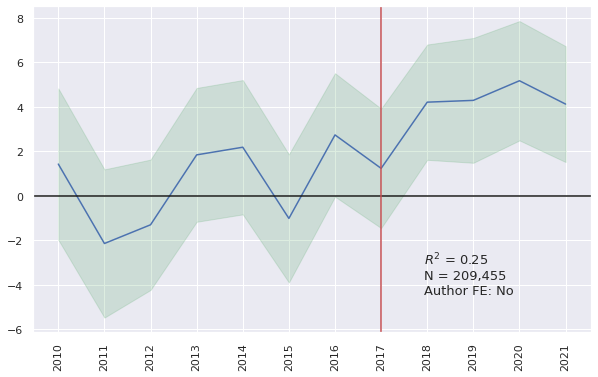

In [17]:
sns.set()
fig, ax = plt.subplots(figsize=(10,6))
regplot(ax, coefs_yr_base,lowbar_base,upbar_base ,int(nobs_base),
        round(r2_base,2))




fig.savefig(results_dir + 'regressions_director.jpg', dpi=300,bbox_inches='tight')

# Heterogeity in Critics' discrimination

In [18]:
df_preds = pd.read_pickle(data_dir + 'Critic_predicted_scores.pkl')
df_preds = df_preds.rename(columns= {'Author': 'author'})
df_cpreds = df_crevs.merge(df_preds[['title_year', 'author', 'predicted_score']],
                          on=['title_year', 'author'], how='left')

In [19]:
# Regressing Predicted vs Actual Scores
df_scr = df_cpreds[['score', 'predicted_score']].dropna()
import scipy as sp
slope, intercept, r, p, se = sp.stats.linregress(df_scr.score, df_scr.predicted_score)
r2 = r**2

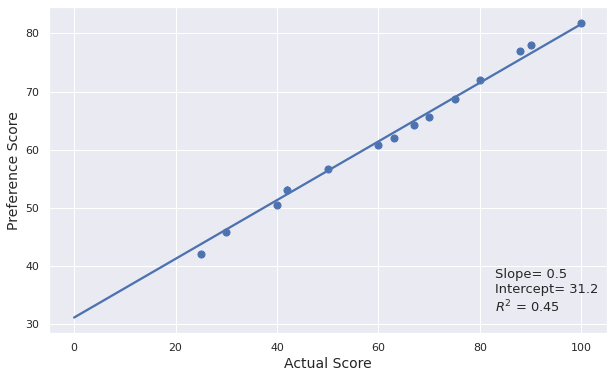

In [20]:
sns.set()
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(y='predicted_score', x='score', data=df_cpreds, x_bins=20)

ax.set_ylabel('Preference Score', fontsize=14)
ax.set_xlabel('Actual Score', fontsize=14)

textstr = '\n'.join(( f'Slope= {round(slope,2)}', f'Intercept= {round(intercept,1)}', 
                     f'$R^2$ = {round(r2,2)}'))

ax.text(0.80, 0.20, textstr, transform=ax.transAxes, fontsize=13,
        verticalalignment='top')

fig.savefig(results_dir + 'binscatter_pred_score.jpg', dpi=300,bbox_inches='tight')

In [21]:
# Critics: Directors and actors

In [22]:
# Stroing the results when pred scores are included
var_authors_wt_pred = critics_reg_results['critics_indiv_bias_with_pred_score']\
                      ['main vars'][2:]
tval_authors_wt_pred = critics_reg_results['critics_indiv_bias_with_pred_score']\
                      ['t_values'][2:]
pval_authors_wt_pred = critics_reg_results['critics_indiv_bias_with_pred_score']\
                      ['p_values'][2:]
coef_authors_wt_pred = critics_reg_results['critics_indiv_bias_with_pred_score']\
                      ['coefs'][2:]
df_authors_disc_wt_pred = pd.DataFrame(data={'author': var_authors_wt_pred, 
                                             'coef': coef_authors_wt_pred,
                                    't-value': tval_authors_wt_pred, 
                                    'p-value': pval_authors_wt_pred})

df_authors_disc_wt_pred = df_authors_disc_wt_pred.loc[np.abs(df_authors_disc_wt_pred['coef'])>1e-10]

In [23]:
# Stroing the results when pred scores are not included
var_authors_wo_pred = critics_reg_results['critics_indiv_bias_wo_pred_score']\
                      ['main vars'][2:]
tval_authors_wo_pred = critics_reg_results['critics_indiv_bias_wo_pred_score']\
                      ['t_values'][2:]
pval_authors_wo_pred = critics_reg_results['critics_indiv_bias_wo_pred_score']\
                      ['p_values'][2:]
coef_authors_wo_pred = critics_reg_results['critics_indiv_bias_wo_pred_score']\
                      ['coefs'][2:]
df_authors_disc_wo_pred = pd.DataFrame(data={'author': var_authors_wo_pred, 
                                             'coef': coef_authors_wo_pred,
                                    't-value': tval_authors_wo_pred, 
                                    'p-value': pval_authors_wo_pred})

df_authors_disc_wt_pred = df_authors_disc_wt_pred.loc[np.abs(df_authors_disc_wt_pred['coef'])>1e-10]

In [24]:
df_authors_disc = df_authors_disc_wt_pred.merge(df_authors_disc_wo_pred, 
                                   on='author', suffixes = (None, '_wo_pred'))

In [25]:
# Benjamini-Hochberg False Discovery Rate_ with predictions
df_authors_sorted = df_authors_disc_wt_pred.sort_values(by='p-value', ignore_index=True)
CDpval_sorted = df_authors_sorted['p-value']
n_C = len(CDpval_sorted)
q = 0.1

# Benjamini-Hochberg FDR Control
C_reject = [[df_authors_sorted['author'][idx], df_authors_sorted['coef'][idx], 
             df_authors_sorted['t-value'][idx], pval] for idx, pval 
            in enumerate(CDpval_sorted) if pval <= (idx+1)*q/n_C]

print(f'Total Number of Authors: {len(df_authors_sorted)}')

print(f'Number of Biased Authors: {len(C_reject)}')

Total Number of Authors: 372
Number of Biased Authors: 12


In [26]:
c_arr = np.asarray(C_reject)
df_biased_critics = pd.DataFrame(data={'author': c_arr[:,0], 'coef': 
                                       c_arr[:,1], 't-value': c_arr[:,2],
                                       'p-value': c_arr[:,3]})

df_biased_critics['coef'] = df_biased_critics['coef'].astype('float')
df_biased_critics['t-value'] = df_biased_critics['t-value'].astype('float')
df_biased_critics = df_biased_critics.sort_values(by='coef', ignore_index=True)


In [27]:
disc_critics = df_biased_critics['author'].tolist()
df_not_biased = df_authors_disc_wt_pred.query('author not in @disc_critics')

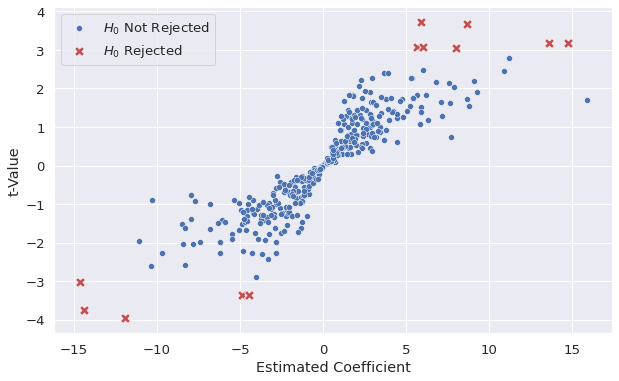

In [28]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x='coef', y='t-value', data=df_not_biased)
sns.scatterplot(x='coef', y='t-value', data=df_biased_critics, color='r',
                marker="X", s=100)

ax.set_xlabel('Estimated Coefficient')
ax.set_ylabel('t-Value')

ax.legend(labels = ["$H_0$ Not Rejected",   "$H_0$ Rejected"])
fig.savefig(results_dir + 'heterogen_scatter.jpg', dpi=300,bbox_inches='tight')